# 1) Imports

#### PyTorch


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR

In [3]:
print('PyTorch version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

PyTorch version 2.9.1+cu128
Device: cuda


#### General

In [4]:
import os
import json
import math
import time
import random
from pathlib import Path
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

#### Monai

In [5]:
import monai
print(monai.__version__)

1.5.1


In [6]:
from monai.networks.nets import AttentionUnet
from monai.losses import DiceCELoss
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    RandAffined,
    RandGaussianNoised,
    RandShiftIntensityd,
    RandScaleIntensityd,
    EnsureTyped,
)

# 2) Parameters

#### 2.1) Directories for the images

In [7]:
train_images_dir = "/home/usrs/hnoel/SPLIT_RAVIR/Train/Images"
train_masks_dir  = "/home/usrs/hnoel/SPLIT_RAVIR/Train/Masks"

val_images_dir   = "/home/usrs/hnoel/SPLIT_RAVIR/Val/Images"
val_masks_dir    = "/home/usrs/hnoel/SPLIT_RAVIR/Val/Masks"

test_images_dir  = "/home/usrs/hnoel/SPLIT_RAVIR/Test/Images"
test_masks_dir   = "/home/usrs/hnoel/SPLIT_RAVIR/Test/Masks"

In [8]:
IMG_HEIGHT = 768
IMG_WIDTH  = 768

BATCH_SIZE = 4
print('Batch size:', BATCH_SIZE)

EPOCHS = 200
print('Number of epochs:', EPOCHS)

LR = 1e-3
print('Initial learning rate:', LR)

"""
0 : background (black)
1 : arteries (white)
2 : veins (gray)
"""
NUM_CLASSES = 3

COLOR_TO_LABEL = {
    (0,   0,   0)  : 0,  # background
    (255, 255, 255): 1,  # artery
    (128, 128, 128): 2,  # vein
}

BACKGROUND_IDX  = 0
ARTERY_CLASS = 1
VEIN_CLASS   = 2

VESSEL_CLASSES  = [1, 2]  # artery + vein

Batch size: 4
Number of epochs: 200
Initial learning rate: 0.001


#### 2.2) Seed

In [9]:
SEED = 42

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Monai
set_determinism(seed=SEED)

print(f"Seed fixed to {SEED}")

Seed fixed to 42


# 3) DataLoaders

#### 3.1) Data augmentation

In [10]:
train_transforms = Compose([
    # --- Géométriques (image + label) ---
    RandFlipd(keys=["image", "label"], prob=0.4, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.4, spatial_axis=1),
    RandRotate90d(keys=["image", "label"], prob=0.3, max_k=3),

    RandZoomd(
        keys=["image", "label"],
        prob=0.3,
        min_zoom=0.9,
        max_zoom=1.1,
        mode=("bilinear", "nearest"),  # image / mask
        keep_size=True,
    ),

    RandAffined(
        keys=["image", "label"],
        prob=0.2,
        rotate_range=(0.15, 0.15),      # ~8.5 degrés
        shear_range=(0.05, 0.05),
        translate_range=(8, 8),
        scale_range=(0.05, 0.05),
        mode=("bilinear", "nearest"),   # bilinear pour image, nearest pour mask
        padding_mode="zeros",
    ),

    # --- Intensité (image seule) ---
    RandGaussianNoised(keys=["image"], prob=0.1, std=0.01),
    RandShiftIntensityd(keys=["image"], prob=0.1, offsets=0.1),
    RandScaleIntensityd(keys=["image"], prob=0.1, factors=0.1),

    # S'assure que tout est bien en tensors PyTorch
    EnsureTyped(keys=["image", "label"]),
])

# Pas d'augmentation sur la validation
val_transforms = None

#### 3.2) Create the class for the dataset images

In [11]:
class RAVIRDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), transforms=None):
        self.img_paths = sorted(list(Path(img_dir).glob("*.png")))
        self.mask_dir = Path(mask_dir)
        self.img_size = img_size
        self.transforms = transforms   # ← pipeline MONAI (ou None)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_dir / img_path.name

        # --- Image ---
        img = Image.open(img_path).convert("RGB").resize(self.img_size, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))           # (C,H,W)
        img_t = torch.from_numpy(img).float()

        # --- Mask ---
        m = Image.open(mask_path).convert("RGB").resize(self.img_size, Image.NEAREST)
        m = np.array(m, dtype=np.uint8)

        label = np.zeros((self.img_size[1], self.img_size[0]), dtype=np.uint8)
        for color, lab in COLOR_TO_LABEL.items():
            mask = np.all(m == np.array(color), axis=-1)
            label[mask] = lab

        label_t = torch.from_numpy(label).long()   # (H,W)
        label_t = label_t.unsqueeze(0)             # (1,H,W) pour MONAI

        # ========= Application des transforms MONAI (si fournies) =========
        if self.transforms is not None:
            sample = {"image": img_t, "label": label_t}
            sample = self.transforms(sample)
            img_t  = sample["image"]
            label_t = sample["label"]

        return img_t, label_t

In [12]:
train_ds = RAVIRDataset(
    train_images_dir,
    train_masks_dir,
    (IMG_WIDTH, IMG_HEIGHT),
    transforms=train_transforms,   # ← augmentation activée
)

val_ds = RAVIRDataset(
    val_images_dir,
    val_masks_dir,
    (IMG_WIDTH, IMG_HEIGHT),
    transforms=val_transforms,     # ← None → pas d’augmentation
)

test_ds = RAVIRDataset(
    test_images_dir,
    test_masks_dir,
    (IMG_WIDTH, IMG_HEIGHT)
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 4) UNet Model

In [13]:
model = AttentionUnet(
    spatial_dims=2,
    in_channels=3,
    out_channels=NUM_CLASSES,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    kernel_size=3,
    up_kernel_size=3,
    dropout=0.0
).to(device)

In [14]:
print(model.__class__.__name__, "initialized on", device)

AttentionUnet initialized on cuda


# 5) Optimizer

In [15]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=1e-2
    )

# 6) Scheduler

In [16]:
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=50,   # tous les 50 epochs
    gamma=0.5       # LR = LR * 0.5
)

# 7) Loss function

In [17]:
percentage = [0.872, 0.054, 0.073]
inverse_percentage = [round((1/p), 2) for p in percentage]
print("Inverse class frequencies:", inverse_percentage)

weights = torch.tensor(inverse_percentage).to(device)

Inverse class frequencies: [1.15, 18.52, 13.7]


In [18]:
loss_function = DiceCELoss(
    include_background=False,
    to_onehot_y=True,
    softmax=True,
    weight=weights,
    lambda_dice=1.0,
    lambda_ce=1.0
)

# 8) History and metrics

In [19]:
best_val_loss = float("inf")
best_val_dice = -float("inf")

model_name = "AU_v2"
save_dir = Path("AttentionUNet") / model_name

save_dir.mkdir(parents=True, exist_ok=True)
last_epoch_save = 0

In [20]:
# ===========================================
#   DICTIONNAIRES STOCRAGE (MEAN ONLY)
# ===========================================

train_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        [],
    "lr":         [],
    "alpha":      []
}

val_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        []
}

In [21]:
def init_confmat_sums(num_classes=NUM_CLASSES):
    """
    Agrégats TP/FP/FN/TN sur l'ensemble du dataset.
    """
    sums = {
        "TP": np.zeros(num_classes, dtype=np.int64),
        "FP": np.zeros(num_classes, dtype=np.int64),
        "FN": np.zeros(num_classes, dtype=np.int64),
        "TN": np.zeros(num_classes, dtype=np.int64),
        "N":  0
    }
    return sums


def init_auc_buffers(include_classes=VESSEL_CLASSES):
    """
    Buffers pour calculer l'AUC par classe (artery / vein).
    """
    return {c: {"y_true": [], "y_score": []} for c in include_classes}


In [22]:
def update_confmat_sums(sums, preds, targets, num_classes=NUM_CLASSES):
    """
    Met à jour les compteurs TP/FP/FN/TN pour chaque classe.
    preds, targets: tensors (N,H,W)
    """
    with torch.no_grad():
        for c in range(num_classes):
            p = (preds == c)
            t = (targets == c)

            tp = (p & t).sum().item()
            fp = (p & ~t).sum().item()
            fn = (~p & t).sum().item()
            tn = (~p & ~t).sum().item()

            sums["TP"][c] += tp
            sums["FP"][c] += fp
            sums["FN"][c] += fn
            sums["TN"][c] += tn

        sums["N"] += targets.numel()

In [23]:
def update_auc_buffers(buffers, logits, targets):
    """
    Stocke y_true / y_score pour calculer l'AUC par classe ensuite.
    - logits: (N,C,H,W)
    - targets: (N,H,W)
    """
    with torch.no_grad():
        probs = F.softmax(logits, dim=1)  # (N,C,H,W)

        # flatten (N,H,W,C) -> (N*H*W, C)
        flat_probs = probs.permute(0, 2, 3, 1).reshape(-1, probs.shape[1])
        flat_t     = targets.reshape(-1)

        for c in buffers.keys():
            y_true  = (flat_t == c).cpu().numpy().astype(np.uint8)
            y_score = flat_probs[:, c].cpu().numpy()
            buffers[c]["y_true"].append(y_true)
            buffers[c]["y_score"].append(y_score)

In [24]:
def compute_scalar_metrics_from_confmat(sums, include_classes):
    """
    Calcule accuracy / precision / recall / specificity / dice / IoU
    en moyenne sur les classes listées (par ex. artery+vein).
    """
    TP, FP, FN, TN = sums["TP"], sums["FP"], sums["FN"], sums["TN"]
    eps = 1e-7

    acc_c  = (TP + TN) / np.maximum(TP + TN + FP + FN, eps)
    prec_c = TP / np.maximum(TP + FP, eps)
    rec_c  = TP / np.maximum(TP + FN, eps)
    spec_c = TN / np.maximum(TN + FP, eps)
    dice_c = (2 * TP) / np.maximum(2 * TP + FP + FN, eps)
    iou_c  = TP / np.maximum(TP + FP + FN, eps)

    idx = np.array(include_classes, dtype=int)
    return {
        "accuracy":    float(np.mean(acc_c[idx])),
        "precision":   float(np.mean(prec_c[idx])),
        "recall":      float(np.mean(rec_c[idx])),
        "specificity": float(np.mean(spec_c[idx])),
        "dice":        float(np.mean(dice_c[idx])),
        "iou":         float(np.mean(iou_c[idx])),
    }

In [25]:
def compute_mean_auc(buffers):
    """
    Calcule l'AUC moyenne sur les classes présentes dans 'buffers'.
    Ignore les cas où la classe n'apparaît jamais.
    """
    aucs = []
    for c, pack in buffers.items():
        if len(pack["y_true"]) == 0:
            continue
        y_true  = np.concatenate(pack["y_true"])
        y_score = np.concatenate(pack["y_score"])

        pos = (y_true == 1).sum()
        neg = (y_true == 0).sum()
        if pos == 0 or neg == 0:
            continue

        try:
            aucs.append(roc_auc_score(y_true, y_score))
        except Exception:
            pass

    if len(aucs) == 0:
        return float("nan")
    return float(np.mean(aucs))

# 9) Training

In [26]:
for epoch in range(EPOCHS):

    # =========================
    #        TRAIN
    # =========================
    model.train()

    running_loss = 0.0
    conf_sums = init_confmat_sums()
    auc_buf   = init_auc_buffers()

    for imgs, masks in train_loader:
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = model(imgs)  # (N,C,H,W)
        loss    = loss_function(outputs, masks)  # Dice + CE (MONAI)

        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size

        preds = outputs.argmax(dim=1)
        update_confmat_sums(conf_sums, preds, masks, NUM_CLASSES)
        update_auc_buffers(auc_buf, outputs, masks)

    train_loss   = running_loss / len(train_ds)
    train_metrics = compute_scalar_metrics_from_confmat(conf_sums, VESSEL_CLASSES)
    train_auc     = compute_mean_auc(auc_buf)

    current_lr = optimizer.param_groups[0]["lr"]

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_metrics["accuracy"])
    train_history["dice"].append(train_metrics["dice"])
    train_history["iou"].append(train_metrics["iou"])
    train_history["precision"].append(train_metrics["precision"])
    train_history["recall"].append(train_metrics["recall"])
    train_history["specificity"].append(train_metrics["specificity"])
    train_history["auc"].append(train_auc)
    train_history["lr"].append(current_lr)

    # =========================
    #       VALIDATION
    # =========================
    model.eval()

    val_running_loss = 0.0
    conf_sums_val = init_confmat_sums()
    auc_buf_val   = init_auc_buffers()

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            outputs = model(imgs)
            loss    = loss_function(outputs, masks)

            batch_size = imgs.size(0)
            val_running_loss += loss.item() * batch_size

            preds = outputs.argmax(dim=1)
            update_confmat_sums(conf_sums_val, preds, masks, NUM_CLASSES)
            update_auc_buffers(auc_buf_val, outputs, masks)

    val_loss    = val_running_loss / len(val_ds)
    val_metrics = compute_scalar_metrics_from_confmat(conf_sums_val, VESSEL_CLASSES)
    val_auc     = compute_mean_auc(auc_buf_val)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_metrics["accuracy"])
    val_history["dice"].append(val_metrics["dice"])
    val_history["iou"].append(val_metrics["iou"])
    val_history["precision"].append(val_metrics["precision"])
    val_history["recall"].append(val_metrics["recall"])
    val_history["specificity"].append(val_metrics["specificity"])
    val_history["auc"].append(val_auc)

    # =========================
    #        LOGS
    # =========================
    print("-" * 40)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    print(f"  Train Dice: {train_metrics['dice']:.4f} | Val Dice: {val_metrics['dice']:.4f}")
    print(f"  Current LR: {current_lr:.6f}")

    # =========================
    #   SAVE BEST MODELS
    # =========================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), str(save_dir / "loss_best_model_state_dict.pth"))
        torch.save(model,              str(save_dir / "loss_best_model_full.pth"))
        print("✅ New best model (loss) saved")

    if val_metrics["dice"] > best_val_dice:
        best_val_dice = val_metrics["dice"]
        torch.save(model.state_dict(), str(save_dir / "dice_best_model_state_dict.pth"))
        torch.save(model,              str(save_dir / "dice_best_model_full.pth"))
        print("✅ New best model (dice) saved")

    # =========================
    #   SCHEDULER STEP
    # =========================
    scheduler.step()

# =========================
#     SAVE LAST MODEL
# =========================
torch.save(model.state_dict(), str(save_dir / f"epoch{EPOCHS}_model_state_dict.pth"))
torch.save(model,              str(save_dir / f"epoch{EPOCHS}_model_full.pth"))
print("✅ Last model saved")


----------------------------------------
Epoch 1/200
  Train Loss: 14.8785
  Val   Loss: 15.3291
  Train Dice: 0.1118 | Val Dice: 0.1127
  Current LR: 0.001000
✅ New best model (loss) saved
✅ New best model (dice) saved
----------------------------------------
Epoch 2/200
  Train Loss: 13.9236
  Val   Loss: 15.2492
  Train Dice: 0.1311 | Val Dice: 0.1057
  Current LR: 0.001000
✅ New best model (loss) saved
----------------------------------------
Epoch 3/200
  Train Loss: 13.5201
  Val   Loss: 15.7597
  Train Dice: 0.1382 | Val Dice: 0.0946
  Current LR: 0.001000
----------------------------------------
Epoch 4/200
  Train Loss: 13.1767
  Val   Loss: 15.5181
  Train Dice: 0.1474 | Val Dice: 0.0986
  Current LR: 0.001000
----------------------------------------
Epoch 5/200
  Train Loss: 12.6649
  Val   Loss: 16.1667
  Train Dice: 0.1592 | Val Dice: 0.1079
  Current LR: 0.001000
----------------------------------------
Epoch 6/200
  Train Loss: 12.4931
  Val   Loss: 14.3294
  Train Dice:

In [27]:
with open(save_dir / "AttentionUNet_train_history.json", "w") as f:
    json.dump(train_history, f, indent=4)

with open(save_dir / "AttentionUNet_val_history.json", "w") as f:
    json.dump(val_history, f, indent=4)

print("Historiques sauvegardés en JSON")

Historiques sauvegardés en JSON


# 10) Loading of the model

In [29]:
model.load_state_dict(torch.load(save_dir / "dice_best_model_state_dict.pth", map_location=device, weights_only=True))
model.eval()

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine

# 11) Validation tests

### 11.1) Images

In [ ]:
model.eval()
total_correct = 0
total_pixels = 0

# 📁 Dossier pour sauvegarder les prédictions
pred_dir = save_dir / "predictions"
pred_dir.mkdir(parents=True, exist_ok=True)

with torch.no_grad():
    img_index = 0  # compteur global des images

    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        # Boucle sur chaque image du batch
        for i in range(len(imgs)):
            pred = preds[i]
            mask = masks[i]

            # ===== Calcul de l’accuracy de cette image =====
            correct_pixels = (pred == mask).sum().item()
            total_pixels_img = mask.numel()
            acc_img = correct_pixels / total_pixels_img

            print(f"🖼️ Image {img_index+1} — Accuracy : {acc_img:.4f}")

            # ===== Création de la figure =====
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            ax[0].set_title("Original picture")
            ax[1].imshow(mask.cpu().squeeze(0), cmap="gray")
            ax[1].set_title("Real mask")
            ax[2].imshow(pred.cpu(), cmap="gray")
            ax[2].set_title("Predicted mask")
            for a in ax:
                a.axis("off")
            plt.tight_layout()

            # 📌 Sauvegarde dans Models/<model_name>/predictions/
            save_path = pred_dir / f"val_img_{img_index:03d}.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')

            # ✅ Affichage immédiat dans notebook
            plt.show()

            # ===== Accumulateur global =====
            total_correct += correct_pixels
            total_pixels += total_pixels_img
            img_index += 1

# ===== Accuracy globale =====
val_acc = total_correct / total_pixels
print(f"\n✅ Accuracy moyenne sur le jeu de validation : {val_acc:.4f}")

### 11.2) Curves

In [30]:
curves_dir = save_dir / "curves"
curves_dir.mkdir(parents=True, exist_ok=True)

In [31]:
def plot_metric(train_history, val_history, key, title=None, mark_best_on="val_loss", save_folder=curves_dir):
    """
    key: nom de la métrique dans les dicts (ex: "loss", "dice", "auc")

    mark_best_on:
        - "val_loss" → marquer l'epoch où val_loss est minimal
        - "val_<key>" → marquer la meilleure valeur validation pour cette métrique (max)
    """

    train = train_history.get(key, [])
    val   = val_history.get(key, [])

    if len(val) == 0:
        print(f"⚠️ Impossible de tracer '{key}' (aucune valeur de validation trouvée)")
        return

    epochs = range(1, len(val) + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, train, label=f"Train {key}", linewidth=2)
    plt.plot(epochs, val,   label=f"Val {key}", linewidth=2)

    # ======== BEST POINT (scatter) =========
    if mark_best_on == "val_loss" and "loss" in val_history:
        # meilleur = minimum
        best_e = int(np.argmin(val_history["loss"])) + 1
        best_v = val[best_e - 1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")

    elif mark_best_on == f"val_{key}" and len(val) > 0:
        # meilleur = maximum
        best_e = int(np.nanargmax(val)) + 1
        best_v = val[best_e - 1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")

    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title or f"{key} (train vs val)")
    plt.grid(True)
    plt.legend()

    save_path = save_folder / f"{key}.png"
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    print(f"💾 Courbe sauvegardée : {save_path}")

    plt.show()


💾 Courbe sauvegardée : AttentionUNet/AU_v1/curves/loss.png


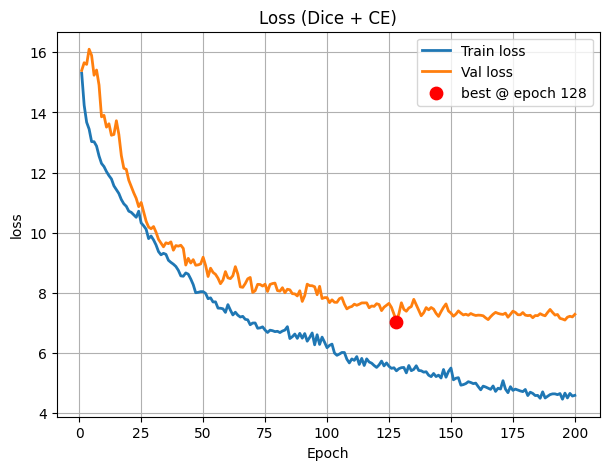

💾 Courbe sauvegardée : AttentionUNet/AU_v1/curves/dice.png


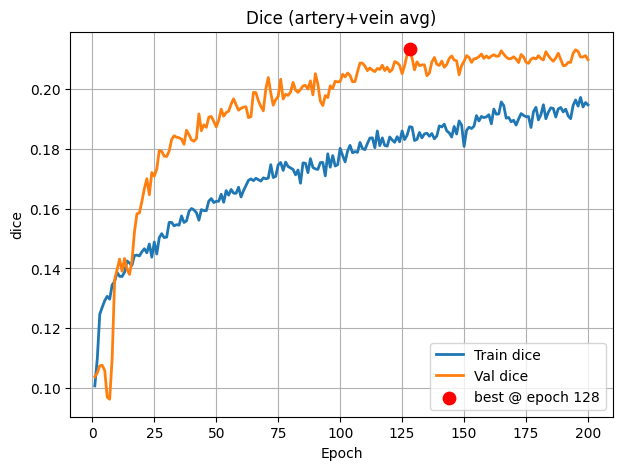

💾 Courbe sauvegardée : AttentionUNet/AU_v1/curves/auc.png


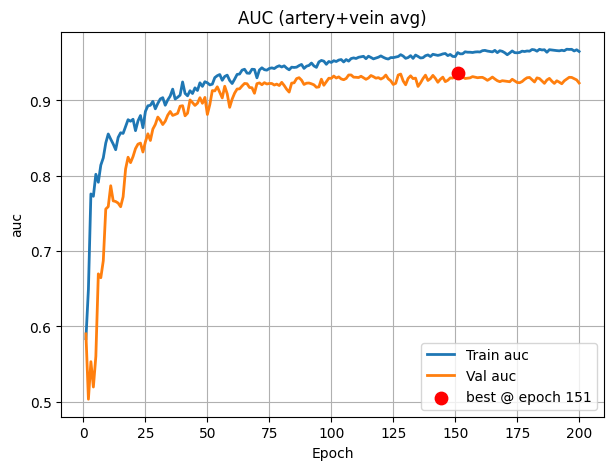

In [31]:
# Loss totale, Dice, AUC : même type de visualisation que dans ton notebook

plot_metric(train_history, val_history, "loss",
            title="Loss (Dice + CE)", mark_best_on="val_loss")

plot_metric(train_history, val_history, "dice",
            title="Dice (artery+vein avg)", mark_best_on="val_dice")

plot_metric(train_history, val_history, "auc",
            title="AUC (artery+vein avg)", mark_best_on="val_auc")

✅ Courbe learning rate sauvegardée dans : AttentionUNet/AU_v1/curves/lr_curve.png


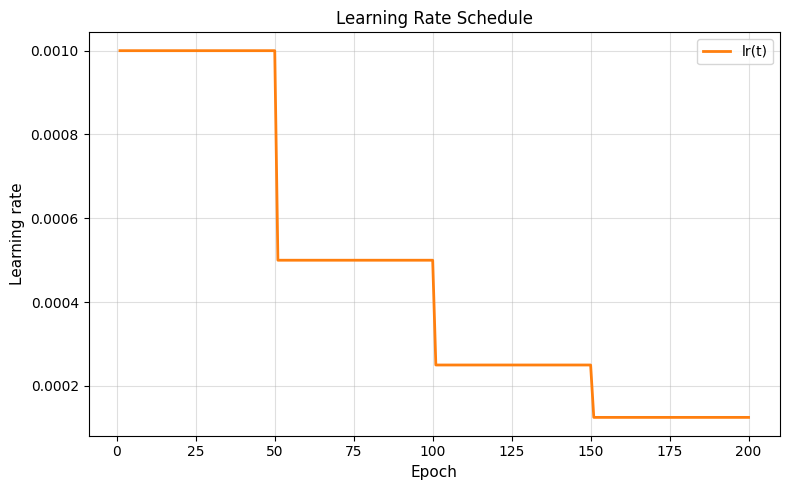

In [32]:
# =========================
#   COURBE LEARNING RATE
# =========================

lr_values = train_history.get("lr", [])
epochs = np.arange(1, len(lr_values) + 1)

fig_lr, ax = plt.subplots(figsize=(8, 5))
ax.plot(epochs, lr_values, color="#ff7f0e", linewidth=2)
ax.set_title("Learning Rate Schedule")
ax.set_xlabel("Epoch", fontsize=11)
ax.set_ylabel("Learning rate", fontsize=11)
ax.grid(alpha=0.4)
ax.legend(["lr(t)"], loc="best")
plt.tight_layout()

lr_path = curves_dir / "lr_curve.png"
plt.savefig(lr_path, dpi=200, bbox_inches='tight')
print(f"✅ Courbe learning rate sauvegardée dans : {lr_path}")

plt.show()

### 11.3) Table of metrics

In [ ]:
# =========================
#  UTILS: métriques par classe
# =========================
def compute_per_class_metrics_from_confmat(sums, c):
    TP, FP, FN, TN = sums["TP"][c], sums["FP"][c], sums["FN"][c], sums["TN"][c]
    eps = 1e-7

    acc  = (TP + TN) / max(TP + TN + FP + FN, eps)
    prec = TP / max(TP + FP, eps)
    rec  = TP / max(TP + FN, eps)
    spec = TN / max(TN + FP, eps)
    dice = (2 * TP) / max(2 * TP + FP + FN, eps)
    iou  = TP / max(TP + FP + FN, eps)

    return {
        "accuracy":   float(acc),
        "precision":  float(prec),
        "recall":     float(rec),      # Sensitivity
        "specificity":float(spec),
        "dice":       float(dice),
        "iou":        float(iou),
    }

def compute_auc_for_class(buffers, c):
    pack = buffers.get(c, None)
    if pack is None or len(pack["y_true"]) == 0:
        return float("nan")

    y_true  = np.concatenate(pack["y_true"])
    y_score = np.concatenate(pack["y_score"])

    pos = (y_true == 1).sum()
    neg = (y_true == 0).sum()
    if pos == 0 or neg == 0:
        return float("nan")

    try:
        return float(roc_auc_score(y_true, y_score))
    except:
        return float("nan")


# =========================
#   ÉVALUATION
# =========================
model.eval()
conf_sums_val = init_confmat_sums(num_classes=NUM_CLASSES)
auc_buf_val   = init_auc_buffers(include_classes=VESSEL_CLASSES)

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        update_confmat_sums(conf_sums_val, preds, masks, NUM_CLASSES)
        update_auc_buffers(auc_buf_val, outputs, masks)


# =========================
#   MÉTRIQUES PAR CLASSE
# =========================
results = {}

for cls, name in zip(VESSEL_CLASSES, ["Artery", "Vein"]):
    m = compute_per_class_metrics_from_confmat(conf_sums_val, cls)
    m["auc"] = compute_auc_for_class(auc_buf_val, cls)
    results[name] = m


# =========================
#   MOYENNES ARTERY + VEIN
# =========================
avg_metrics = {metric: np.nanmean([results["Artery"][metric], results["Vein"][metric]])
               for metric in results["Artery"].keys()}

results["Average (A+V)"] = avg_metrics


# =========================
#   AFFICHAGE TABLEAU (4 décimales)
# =========================
df = pd.DataFrame(results).T
df = df.round(4)  # <= Arrondi propre à 4 décimales

print("\n=== Résultats de validation ===\n")
display(df.style.format("{:.4f}"))

In [ ]:
# =========================
#   PER-IMAGE METRIC HELPERS
# =========================
def dice_per_image(pred, target, cls):
    eps = 1e-7
    p = (pred == cls).float()
    t = (target == cls).float()
    inter = (p * t).sum()
    denom = p.sum() + t.sum()
    return float((2.0 * inter) / (denom + eps))

def iou_per_image(pred, target, cls):
    eps = 1e-7
    p = (pred == cls)
    t = (target == cls)
    inter = (p & t).sum().item()
    union = (p | t).sum().item()
    return float(inter / (union + eps))

def auc_per_image_from_logits(logits, target, cls):
    # logits: (C,H,W) for a single image
    probs = F.softmax(logits, dim=0)
    y_score = probs[cls].reshape(-1).cpu().numpy()
    y_true  = (target == cls).reshape(-1).cpu().numpy().astype(np.uint8)
    pos = (y_true == 1).sum()
    neg = (y_true == 0).sum()
    if pos == 0 or neg == 0:
        return float("nan")
    try:
        return float(roc_auc_score(y_true, y_score))
    except Exception:
        return float("nan")

# =========================
#   COLLECT PER-IMAGE METRICS
# =========================
model.eval()

artery_dice_list, vein_dice_list, avg_dice_list = [], [], []
artery_iou_list,  vein_iou_list,  avg_iou_list  = [], [], []
artery_auc_list,  vein_auc_list,  avg_auc_list  = [], [], []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)          # (N,C,H,W)
        preds  = logits.argmax(dim=1) # (N,H,W)

        for i in range(imgs.size(0)):
            p   = preds[i]
            gt  = masks[i]
            log = logits[i]

            # Dice
            a_d = dice_per_image(p, gt, ARTERY_CLASS)
            v_d = dice_per_image(p, gt, VEIN_CLASS)
            artery_dice_list.append(a_d)
            vein_dice_list.append(v_d)
            avg_dice_list.append(np.nanmean([a_d, v_d]))

            # IoU
            a_i = iou_per_image(p, gt, ARTERY_CLASS)
            v_i = iou_per_image(p, gt, VEIN_CLASS)
            artery_iou_list.append(a_i)
            vein_iou_list.append(v_i)
            avg_iou_list.append(np.nanmean([a_i, v_i]))

            # AUC
            a_auc = auc_per_image_from_logits(log, gt, ARTERY_CLASS)
            v_auc = auc_per_image_from_logits(log, gt, VEIN_CLASS)
            artery_auc_list.append(a_auc)
            vein_auc_list.append(v_auc)
            avg_auc_list.append(np.nanmean([a_auc, v_auc]))

# =========================
#   BAR PLOTS (3 rows × 3 cols)
#   One bar per image; red dashed = mean
# =========================
def plot_bars_one_metric(ax, values, title):
    values = np.array(values, dtype=float)
    n = len(values)
    x = np.arange(1, n+1)

    ax.bar(x, values, color="#1f77b4", edgecolor="black", alpha=0.9)

    m = np.nanmean(values)
    ax.axhline(m, color="red", linestyle="--", linewidth=2, label=f"mean = {m:.3f}")

    ax.set_ylim(0, 1)            # metrics in [0,1]
    ax.set_xlim(0.5, n + 0.5)
    ax.set_xlabel("Validation image index")
    ax.set_ylabel("Score")
    ax.set_title(title)
    # lighten x ticks if many images
    if n > 30:
        ax.set_xticks(np.linspace(1, n, 10, dtype=int))
    ax.grid(axis="y", alpha=0.3)
    ax.legend(loc="upper right")

fig, axes = plt.subplots(3, 3, figsize=(20, 12), constrained_layout=True)

# Row 1: Dice
plot_bars_one_metric(axes[0,0], artery_dice_list, "Dice – Artery")
plot_bars_one_metric(axes[0,1], vein_dice_list,   "Dice – Vein")
plot_bars_one_metric(axes[0,2], avg_dice_list,    "Dice – Average (A+V)")

# Row 2: IoU
plot_bars_one_metric(axes[1,0], artery_iou_list, "IoU – Artery")
plot_bars_one_metric(axes[1,1], vein_iou_list,   "IoU – Vein")
plot_bars_one_metric(axes[1,2], avg_iou_list,    "IoU – Average (A+V)")

# Row 3: AUC
plot_bars_one_metric(axes[2,0], artery_auc_list, "AUC – Artery")
plot_bars_one_metric(axes[2,1], vein_auc_list,   "AUC – Vein")
plot_bars_one_metric(axes[2,2], avg_auc_list,    "AUC – Average (A+V)")

save_path = curves_dir / f"per_image_metrics_bars.png"
plt.savefig(save_path, dpi=200, bbox_inches='tight')
print(f"💾 Courbe sauvegardée : {save_path}")

plt.show()

### 11.2) New shit

In [33]:
# =========================
# 11) Metric helper functions (artery / vein, no background)
# =========================

import numpy as np
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

def confusion_binary(pred_bin: torch.Tensor, gt_bin: torch.Tensor):
    """
    pred_bin, gt_bin : tensors bool ou 0/1 de shape (H, W).
    Retourne TP, FP, FN, TN.
    """
    pred_bin = pred_bin.bool()
    gt_bin   = gt_bin.bool()

    TP = (pred_bin & gt_bin).sum().item()
    FP = (pred_bin & ~gt_bin).sum().item()
    FN = (~pred_bin & gt_bin).sum().item()
    TN = (~pred_bin & ~gt_bin).sum().item()
    return TP, FP, FN, TN


def metrics_from_confusion(TP, FP, FN, TN):
    """
    Calcule F1 (=Dice binaire), IoU, Accuracy, Sensitivity (SE), Specificity (SP)
    à partir d'une matrice de confusion binaire.
    """
    eps = 1e-8
    acc = (TP + TN) / (TP + TN + FP + FN + eps)
    se  = TP / (TP + FN + eps)               # Sensitivity / Recall
    sp  = TN / (TN + FP + eps)               # Specificity
    f1  = (2 * TP) / (2 * TP + FP + FN + eps)  # F1-score = Dice
    iou = TP / (TP + FP + FN + eps)

    return {
        "F1":  float(f1),
        "IoU": float(iou),
        "Acc": float(acc),
        "SE":  float(se),
        "SP":  float(sp),
    }


def metrics_for_class(pred_labels: torch.Tensor,
                      gt_labels: torch.Tensor,
                      cls: int):
    """
    pred_labels, gt_labels : (H, W) entiers dans {0,1,2}
    cls : ARTERY_CLASS ou VEIN_CLASS

    Retourne dict métriques (sans AUC).
    """
    pred_c = (pred_labels == cls)
    gt_c   = (gt_labels == cls)
    TP, FP, FN, TN = confusion_binary(pred_c, gt_c)
    return metrics_from_confusion(TP, FP, FN, TN)


def auc_from_logits_one_class(logits: torch.Tensor,
                              gt_labels: torch.Tensor,
                              cls: int):
    """
    logits : (C, H, W) pour une image
    gt_labels : (H, W) entiers
    cls : ARTERY_CLASS ou VEIN_CLASS

    AUC ROC binaire pour la classe 'cls'.
    """
    # Probabilités softmax pour la classe d'intérêt
    with torch.no_grad():
        probs = F.softmax(logits, dim=0)[cls]    # (H, W)
        y_score = probs.detach().cpu().flatten().numpy()
        y_true  = (gt_labels == cls).detach().cpu().flatten().numpy().astype(int)

    # Cas dégénérés : que des 0 ou que des 1
    if y_true.max() == y_true.min():
        return float("nan")

    try:
        return float(roc_auc_score(y_true, y_score))
    except Exception:
        return float("nan")

[Image 001] F1: artery=0.738, vein=0.637 | IoU: artery=0.585, vein=0.467


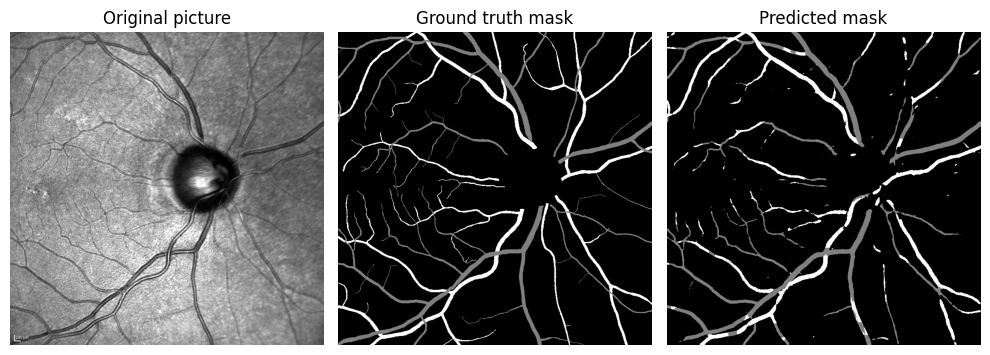

[Image 002] F1: artery=0.743, vein=0.643 | IoU: artery=0.591, vein=0.474


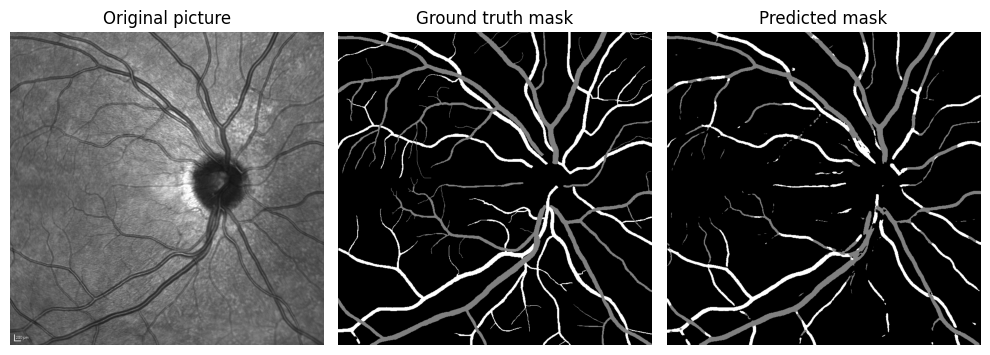

[Image 003] F1: artery=0.673, vein=0.620 | IoU: artery=0.507, vein=0.449


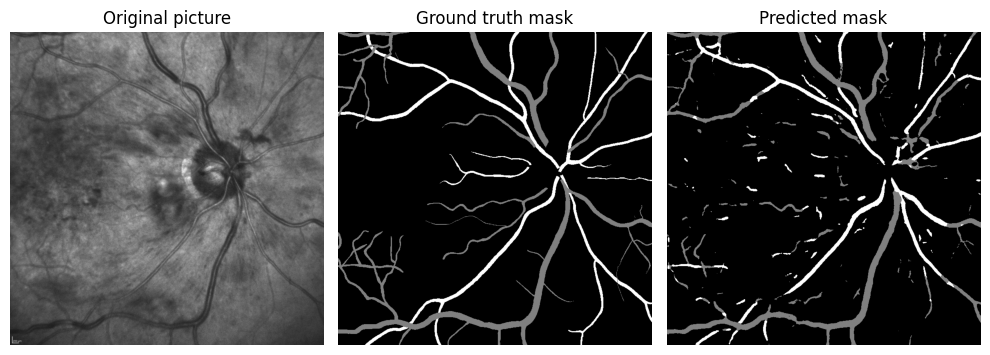

[Image 004] F1: artery=0.676, vein=0.536 | IoU: artery=0.511, vein=0.366


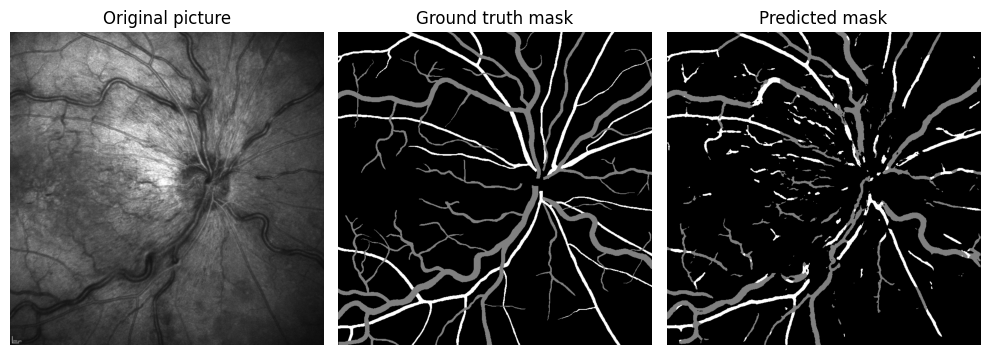

[Image 005] F1: artery=0.557, vein=0.397 | IoU: artery=0.386, vein=0.248


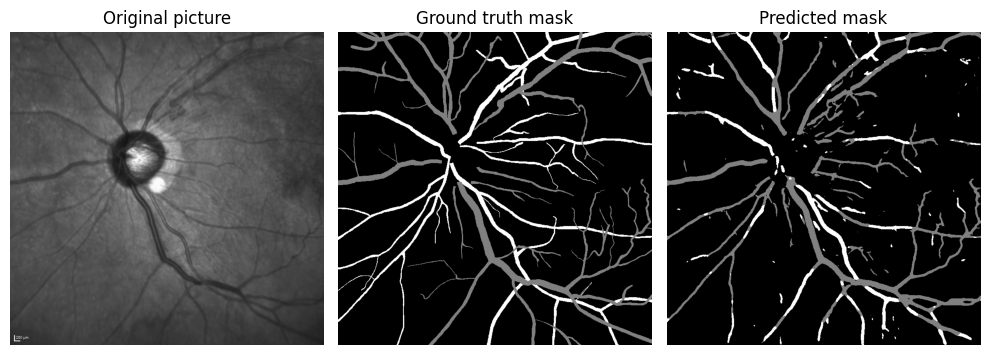


=== Test set metrics (artery / vein / average, no background) ===



,F1,IoU,Acc,SE,SP,AUC
Artery,0.6775,0.5160,0.9508,0.6561,0.9764,0.9321
Vein,0.5667,0.4009,0.9562,0.5246,0.9820,0.9097
Average (A+V),0.6221,0.4585,0.9535,0.5903,0.9792,0.9209



💾 Matrice de barplots sauvegardée : AttentionUNet/AU_v2/per_image_metrics_test.png


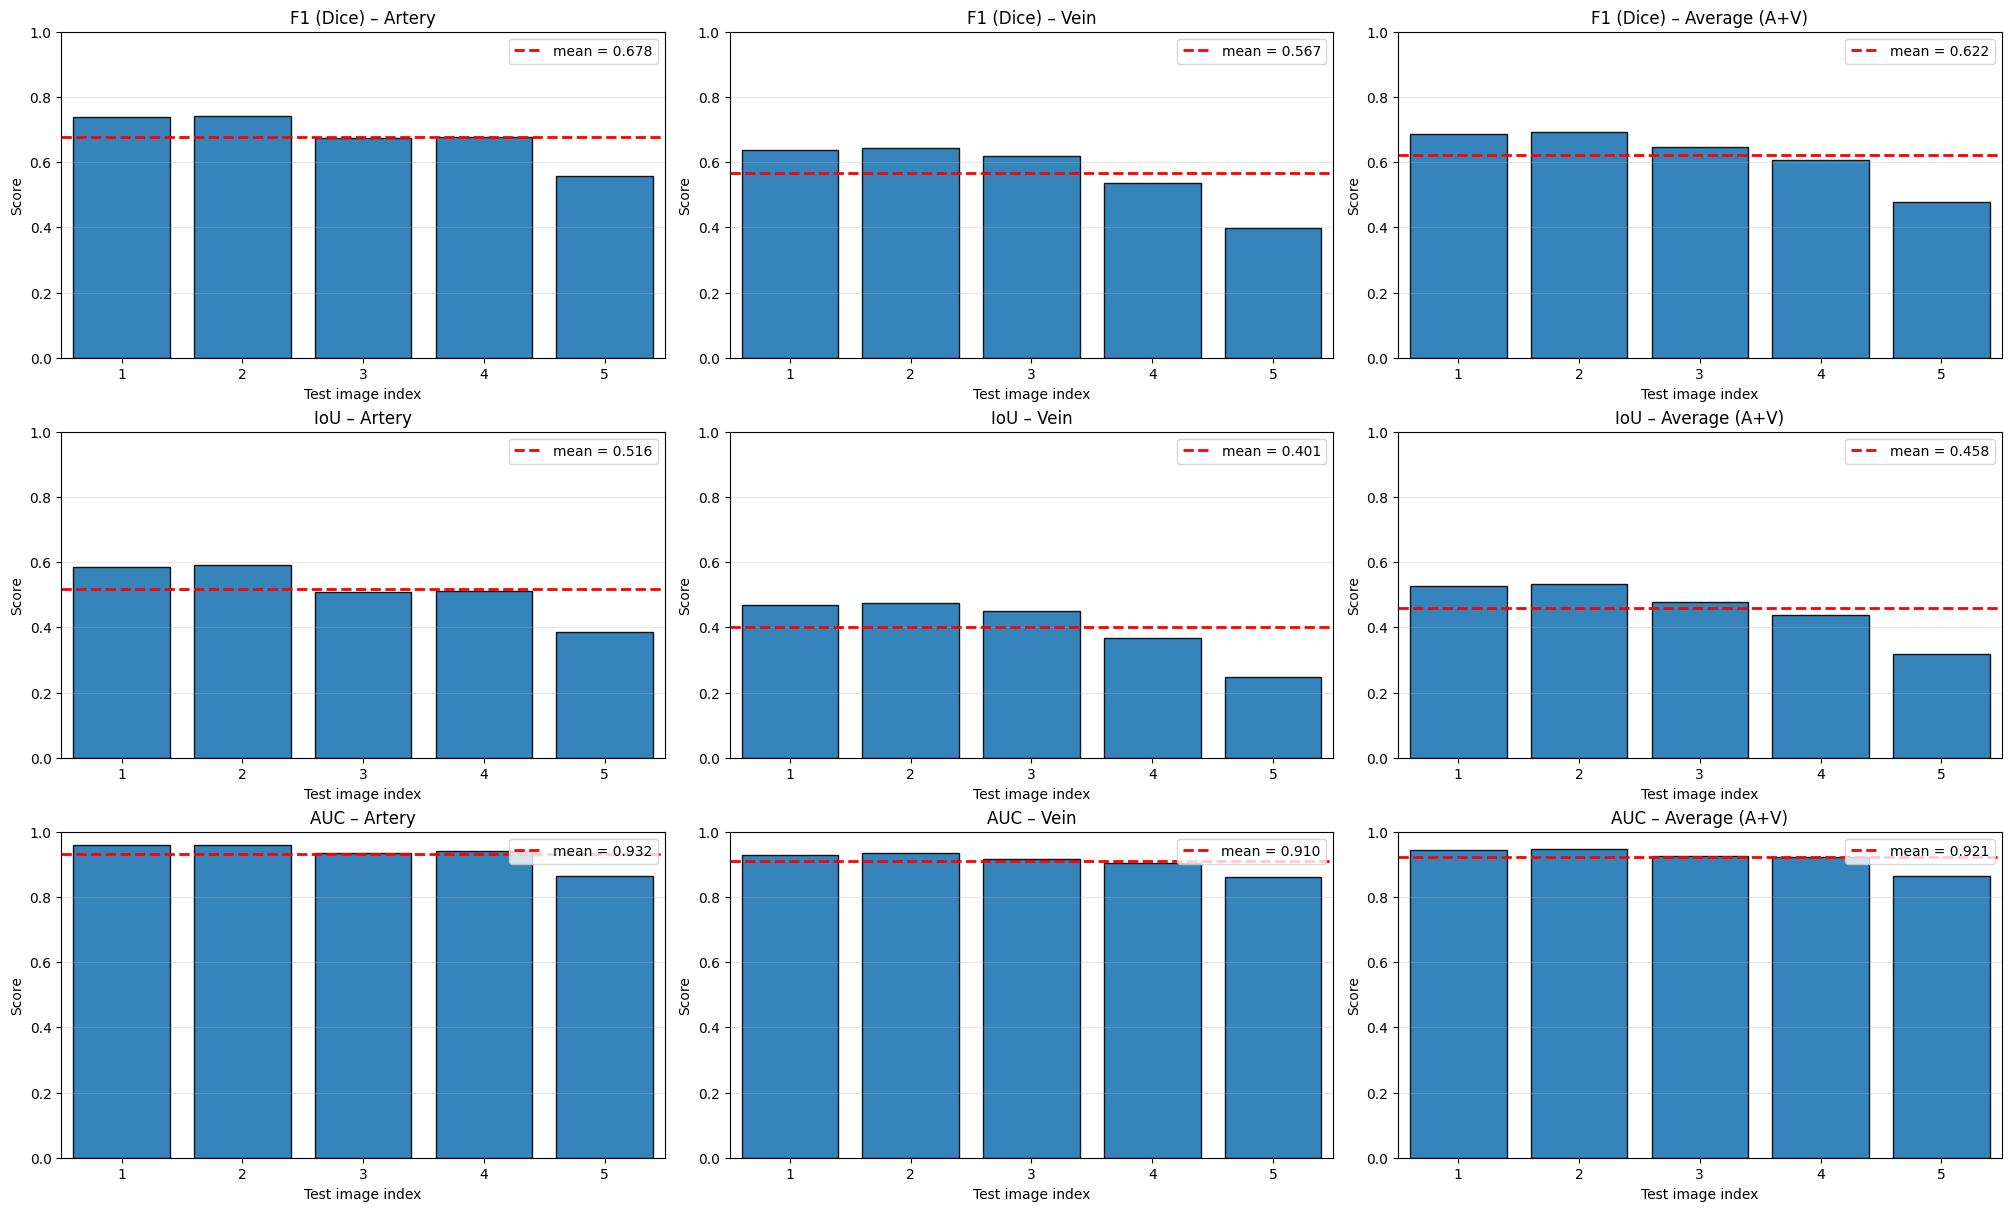

In [34]:
# =========================
# 11.1) Test set: metrics + images + barplots
# =========================

model.eval()

# 📁 Dossier pour sauvegarder les triptyques (original / GT / pred)
pred_dir = save_dir / "predictions_test"
pred_dir.mkdir(parents=True, exist_ok=True)

# Stockage des métriques par image et par classe
metric_names = ["F1", "IoU", "Acc", "SE", "SP", "AUC"]

artery_scores = {m: [] for m in metric_names}
vein_scores   = {m: [] for m in metric_names}

# Pour les barplots "Average (A+V)" sur F1 / IoU / AUC
avg_F1_list  = []
avg_IoU_list = []
avg_AUC_list = []

img_index = 0

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs   = imgs.to(device)          # (B, 3, H, W)
        masks  = masks.to(device)         # (B, 1, H, W)
        logits = model(imgs)              # (B, C, H, W)
        preds  = logits.argmax(dim=1)     # (B, H, W)
        targets = masks.squeeze(1)        # (B, H, W)

        for i in range(imgs.size(0)):
            img = imgs[i].cpu()
            pred = preds[i]
            gt   = targets[i]
            log  = logits[i]

            # ======= Metrics pour ARTERY & VEIN (sans background) =======
            art_metrics  = metrics_for_class(pred, gt, ARTERY_CLASS)
            vein_metrics = metrics_for_class(pred, gt, VEIN_CLASS)

            # AUC
            art_auc  = auc_from_logits_one_class(log, gt, ARTERY_CLASS)
            vein_auc = auc_from_logits_one_class(log, gt, VEIN_CLASS)
            art_metrics["AUC"]  = art_auc
            vein_metrics["AUC"] = vein_auc

            # Stockage pour chaque métrique
            for m in metric_names:
                artery_scores[m].append(art_metrics[m])
                vein_scores[m].append(vein_metrics[m])

            # Moyennes par image (A+V) pour F1 / IoU / AUC
            avg_F1_list.append(0.5 * (art_metrics["F1"]  + vein_metrics["F1"]))
            avg_IoU_list.append(0.5 * (art_metrics["IoU"] + vein_metrics["IoU"]))
            avg_AUC_list.append(0.5 * (art_metrics["AUC"] + vein_metrics["AUC"]))

            # ======= Log console par image (optionnel) =======
            print(
                f"[Image {img_index+1:03d}] "
                f"F1: artery={art_metrics['F1']:.3f}, vein={vein_metrics['F1']:.3f} | "
                f"IoU: artery={art_metrics['IoU']:.3f}, vein={vein_metrics['IoU']:.3f}"
            )

            # ======= Triptyque : original / GT / pred =======
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))

            # Image originale
            ax[0].imshow(img.permute(1, 2, 0))
            ax[0].set_title("Original picture")

            # Masque ground truth
            ax[1].imshow(gt.cpu(), cmap="gray")
            ax[1].set_title("Ground truth mask")

            # Masque prédit
            ax[2].imshow(pred.cpu(), cmap="gray")
            ax[2].set_title("Predicted mask")

            for a in ax:
                a.axis("off")
            plt.tight_layout()

            # Sauvegarde
            save_path = pred_dir / f"test_img_{img_index:03d}.png"
            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            plt.show()

            img_index += 1

# =========================
#  RÉSUMÉ GLOBAL : TABLEAU DES MÉTRIQUES
# =========================

results = {}

# Moyennes sur toutes les images pour chaque classe
artery_mean = {m: float(np.nanmean(artery_scores[m])) for m in metric_names}
vein_mean   = {m: float(np.nanmean(vein_scores[m]))   for m in metric_names}

results["Artery"] = artery_mean
results["Vein"]   = vein_mean

# Moyenne (A+V)
results["Average (A+V)"] = {
    m: float(np.nanmean([artery_mean[m], vein_mean[m]])) for m in metric_names
}

df_test = pd.DataFrame(results).T
df_test = df_test[metric_names]  # ordre des colonnes
df_test = df_test.round(4)

print("\n=== Test set metrics (artery / vein / average, no background) ===\n")
display(df_test)


# =========================
#  MATRICE DE BARPLOTS (comme avant)
#  Row 1: F1 (Dice), Row 2: IoU, Row 3: AUC
# =========================

def plot_bars_one_metric(ax, values, title):
    values = np.array(values, dtype=float)
    n = len(values)
    x = np.arange(1, n + 1)

    ax.bar(x, values, color="#1f77b4", edgecolor="black", alpha=0.9)

    m = np.nanmean(values)
    ax.axhline(m, color="red", linestyle="--", linewidth=2, label=f"mean = {m:.3f}")

    ax.set_ylim(0, 1)
    ax.set_xlim(0.5, n + 0.5)
    ax.set_xlabel("Test image index")
    ax.set_ylabel("Score")
    ax.set_title(title)
    if n > 30:
        ax.set_xticks(np.linspace(1, n, 10, dtype=int))
    ax.grid(axis="y", alpha=0.3)
    ax.legend(loc="upper right")


fig, axes = plt.subplots(3, 3, figsize=(20, 12), constrained_layout=True)

# Row 1 : F1 (= Dice binaire)
plot_bars_one_metric(axes[0, 0], artery_scores["F1"], "F1 (Dice) – Artery")
plot_bars_one_metric(axes[0, 1], vein_scores["F1"],   "F1 (Dice) – Vein")
plot_bars_one_metric(axes[0, 2], avg_F1_list,         "F1 (Dice) – Average (A+V)")

# Row 2 : IoU
plot_bars_one_metric(axes[1, 0], artery_scores["IoU"], "IoU – Artery")
plot_bars_one_metric(axes[1, 1], vein_scores["IoU"],   "IoU – Vein")
plot_bars_one_metric(axes[1, 2], avg_IoU_list,         "IoU – Average (A+V)")

# Row 3 : AUC
plot_bars_one_metric(axes[2, 0], artery_scores["AUC"], "AUC – Artery")
plot_bars_one_metric(axes[2, 1], vein_scores["AUC"],   "AUC – Vein")
plot_bars_one_metric(axes[2, 2], avg_AUC_list,         "AUC – Average (A+V)")

bars_path = save_dir / "per_image_metrics_test.png"
plt.savefig(bars_path, dpi=200, bbox_inches="tight")
print(f"\n💾 Matrice de barplots sauvegardée : {bars_path}")

plt.show()

lol